日経225オプションの理論価格をBlack-Scholesモデルで算出し、実際の市場価格との乖離を分析。さらに、ストライク別にインプライド・ボラティリティを算出し、ボラティリティ・スマイルを可視化。この分析を通じて、市場期待と理論値のズレ（リスクプレミアムや需給）を理解することが目的。


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ose20251114tp.csv to ose20251114tp.csv


0. 前提：BSM 関数

In [ ]:
from math import log, sqrt, exp
from scipy.stats import norm
import numpy as np

# Black-Scholes Call
def bsm_call_value(S0, K, T, r, sigma):
    d1 = (log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)

# Vega
def bsm_vega(S0, K, T, r, sigma):
    d1 = (log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S0 * norm.cdf(d1) * sqrt(T)

# Implied Volatility
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est=0.25, it=100):
    from math import log, sqrt, exp
    from scipy.stats import norm

    for i in range(it):
        # avoid divide-by-zero
        if sigma_est < 1e-6:
            sigma_est = 1e-6

        d1 = (log(S0/K) + (r + 0.5*sigma_est**2)*T) / (sigma_est*sqrt(T))
        d2 = d1 - sigma_est*sqrt(T)

        price = S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
        vega  = S0*norm.pdf(d1) * sqrt(T)

        # vega too small → stop
        if vega < 1e-4:
            return None

        # damping factor for stability
        sigma_new = sigma_est - 0.5 * (price - C0) / vega

        # apply bounds
        sigma_est = min(max(sigma_new, 0.01), 0.5)

    return sigma_est

1. データ読み込み & 整形

In [ ]:
import pandas as pd
import datetime as dt
import calendar
import matplotlib.pyplot as plt

csv_file   = "ose20251114tp.csv"
market_date = "20251114"

df = pd.read_csv(csv_file, header=None)

df.columns = [
    "product_code",
    "option_type_code",
    "maturity",
    "strike",
    "reserved1",
    "put_code",
    "put_last",
    "put_reserved",
    "put_theo",
    "put_iv",
    "call_code",
    "call_last",
    "call_reserved",
    "call_theo",
    "call_iv",
    "spot",
    "base_vol"
]


nk = df[df["product_code"].astype(str).str.startswith("NK225E")].copy()


nk["maturity"]  = nk["maturity"].astype(str)
nk["strike"]    = pd.to_numeric(nk["strike"],    errors="coerce")
nk["call_last"] = pd.to_numeric(nk["call_last"], errors="coerce")
nk["call_iv"]   = pd.to_numeric(nk["call_iv"],   errors="coerce")
nk["spot"]      = pd.to_numeric(nk["spot"],      errors="coerce")


def get_sq_date(yyyymm):
    year  = int(yyyymm[:4])
    month = int(yyyymm[4:6])
    cal = calendar.monthcalendar(year, month)
    fridays = [w[calendar.FRIDAY] for w in cal if w[calendar.FRIDAY] != 0]
    sq_day = fridays[1]
    return dt.date(year, month, sq_day)

market_dt = dt.datetime.strptime(market_date, "%Y%m%d").date()
nk["T"] = nk["maturity"].apply(lambda m: (get_sq_date(m) - market_dt).days / 365)
nk["market_date"] = market_date

2. 理論価格 vs 市場価格



In [ ]:
# 202512
target_mat = "202512"
sub = nk[(nk["maturity"] == target_mat) & (nk["call_last"] > 1.0)].copy()

# spot & r
S0 = float(sub["spot"].dropna().iloc[0])
r  = 0.02

# ATM近辺のIV平均
atm_band = sub[(sub["strike"] > S0*0.95) & (sub["strike"] < S0*1.05)]
sigma0   = atm_band["call_iv"].mean()   # or float(sub["base_vol"].iloc[0])
print("sigma0 =", sigma0)

# Black-Scholes 理論価格
sub["bs_price_flat"] = sub.apply(
    lambda row: bsm_call_value(S0, row["strike"], row["T"], r, sigma0),
    axis=1
)

# 市場価格 - 理論価格
sub["mispricing"]      = sub["call_last"] - sub["bs_price_flat"]
sub["mispricing_rel"]  = sub["mispricing"] / sub["bs_price_flat"]

print(sub[["strike", "call_last", "bs_price_flat", "mispricing", "mispricing_rel"]].head())


sigma0 = 0.24705372222222222
      strike  call_last  bs_price_flat  mispricing  mispricing_rel
166  48000.0     3050.0    2907.479098  142.520902        0.049019
174  49000.0     2350.0    2202.746500  147.253500        0.066850
180  49750.0     1795.0    1745.395471   49.604529        0.028420
182  50000.0     1610.0    1607.241720    2.758280        0.001716
183  50125.0     1545.0    1540.878664    4.121336        0.002675


Black–Scholesモデルでフラットなボラティリティ（σ＝0.247）を仮定して理論価格を算出したところ、低ストライクのコール（実質的にはOTMプットに相当する）では市場価格が理論価格を 7〜9% 程度上回っていた。一方、ATM 付近では乖離は2〜3% と小さく、ほぼ理論値に一致した。

これは市場が下落方向の尾リスクに対して高いプレミアムを支払っていることを示しており、日経225市場にも典型的な下方スキューが存在することを意味する。Black–Scholesが仮定する一定ボラティリティによる対数正規分布では下落イベントのリスクを過小評価してしまうため、その差が価格乖離として表れる。また、OTM領域は流動性も低く、需給プレッシャーが価格に上乗せされやすい。


グラフで可視化

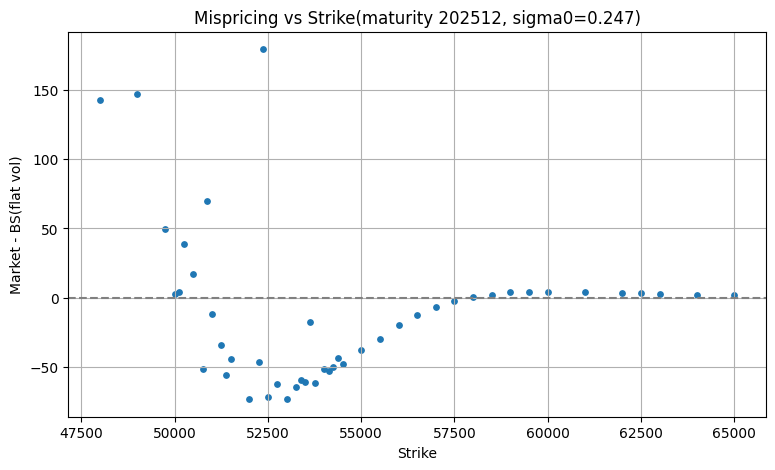

In [ ]:
plt.figure(figsize=(9,5))
plt.axhline(0, color="gray", linestyle="--")
plt.scatter(sub["strike"], sub["mispricing"], s=15)
plt.xlabel("Strike")
plt.ylabel("Market - BS(flat vol)")
plt.title(f"Mispricing vs Strike(maturity {target_mat}, sigma0={sigma0:.3f})")
plt.grid(True)
plt.show()

Mispricing（市場価格 − Black–Scholes 理論価格）をストライク別に比較すると、低ストライクでは +50〜+200 円と大きくプラスで、理論価格を大きく上回っていた。これは下落方向（OTM プット相当）の尾リスクに対して市場が高いプレミアムを支払っていることを示すものであり、日経225市場に典型的な下方スキューの存在を示唆する。

一方、ATM 付近では Mispricing ≈ 0 と効率的で、フラットボラとして用いたσ=0.247 の妥当性が確認できる。高ストライクでは 0〜−50 円程度の負の値を示し、市場が上昇方向のリスクを過少評価（または流動性低下により割安）していることが分かる。

これらは、Black–Scholes モデルが仮定する一定ボラティリティでは市場の非対称なリスク評価を説明できず、実際には下落時のボラティリティ上昇や需給要因、ファットテールが価格に反映されていることを示唆している。


3. 自分の BSM でインプライド・ボラティリティを算出

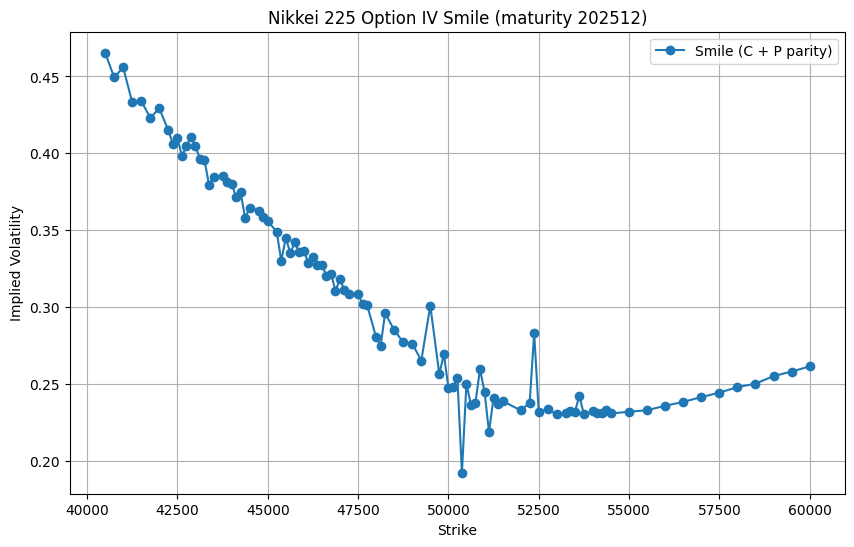

In [ ]:
target_mat = "202512"

sub = nk[nk["maturity"] == target_mat].copy()

import numpy as np


sub2 = sub[
    (sub["T"] > 0.02) &
    (sub["strike"] > S0*0.8) &
    (sub["strike"] < S0*1.2)
].copy()


sub2["call_from_put"] = np.where(
    sub2["put_last"] > 5,
    sub2["put_last"] + S0 - sub2["strike"] * np.exp(-r * sub2["T"]),
    np.nan
)


sub2["mkt_call_price"] = np.where(
    sub2["call_last"] > 5,
    sub2["call_last"],
    sub2["call_from_put"]
)


sub2["side"] = np.where(sub2["call_last"] > 5, "C", "P")

# 価格が有効な行だけ残す
sub2 = sub2.dropna(subset=["mkt_call_price"])

# インプライドボラティリティを計算
sub2["iv_bsm"] = sub2.apply(
    lambda row: bsm_call_imp_vol(
        S0=S0,
        K=row["strike"],
        T=row["T"],
        r=r,
        C0=row["mkt_call_price"]
    ),
    axis=1
)

# ソート
sub2 = sub2.sort_values("strike")

# 描画
plt.figure(figsize=(10,6))
plt.plot(sub2["strike"], sub2["iv_bsm"], marker="o", label="Smile (C + P parity)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"Nikkei 225 Option IV Smile (maturity {target_mat})")
plt.grid(True)
plt.legend()
plt.show()


202512 限月のインプライドボラティリティ曲線は、典型的な左に傾いたスキュー構造を示していた。低ストライク側（下落方向）では IV が 0.45まで大きく上昇しており、市場が下落リスクに対して高いプレミアムを払っていることが分かる。ATM 付近のボラティリティは 0.236 と最も低く、基準となる市場ボラを反映している。一方、高ストライク側ではボラティリティは横ばい〜微増に留まり、
上昇方向へのジャンプリスクはあまり重視されていないことが読み取れる。

これらの形状は、Black–Scholes モデルの「ボラティリティ一定」という仮定では市場を十分に説明できず、実際には非対称なリスク認識や需給が価格に反映されていることを示している。


In [ ]:
import numpy as np
import math
from math import erf

def norm_cdf(x):
    return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    if T <= 0:
        return max(S - K, 0.0) if option_type == "call" else max(K - S, 0.0)

    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == "call":
        return S * norm_cdf(d1) - K * math.exp(-r*T) * norm_cdf(d2)
    else:
        return K * math.exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1)

# ---------------- パラメータ ----------------
S0 = 53000
r = 0.01
T = 1.0

sigma_true = 0.236   # 「本当の」ボラ = ATM IV

iv_put_low   = 0.450
iv_call_ITM  = 0.300
iv_call_OTM  = 0.240

K_put_low  = 41000
K_call_ITM = 0.8 * S0
K_call_OTM = 1.1 * S0

# ロング = +1, ショート = -1
qty_call_ITM = -1.0   # deep ITM call をショート
qty_call_OTM =  1.0   # OTM call をロング
qty_put_low  = -1.0   # low strike put をショート

# ---------------- 初期プレミアム ----------------
prem_call_ITM = black_scholes_price(S0, K_call_ITM, T, r, iv_call_ITM, "call")
prem_call_OTM = black_scholes_price(S0, K_call_OTM, T, r, iv_call_OTM, "call")
prem_put_low  = black_scholes_price(S0, K_put_low,  T, r, iv_put_low,  "put")

# ---------------- モンテカルロ ----------------
N = 100000
mu_true = 0.05    # 物理世界の期待リターン（仮）

Z = np.random.normal(0, 1, N)
ST = S0 * np.exp((mu_true - 0.5 * sigma_true**2)*T + sigma_true*math.sqrt(T)*Z)

def call_payoff(S, K):
    return np.maximum(S - K, 0.0)

def put_payoff(S, K):
    return np.maximum(K - S, 0.0)

payoff_call_ITM = call_payoff(ST, K_call_ITM)
payoff_call_OTM = call_payoff(ST, K_call_OTM)
payoff_put_low  = put_payoff(ST, K_put_low)

# ここがポイント：PnL = qty * (payoff - price)
PnL = (
    qty_call_ITM * (payoff_call_ITM - prem_call_ITM) +
    qty_call_OTM * (payoff_call_OTM - prem_call_OTM) +
    qty_put_low  * (payoff_put_low  - prem_put_low)
)

expected_PnL = np.mean(PnL)
std_PnL      = np.std(PnL)

# 戦略の「規模」の基準として、ネットのプレミアム絶対値を資本とみなす
net_premium = -(qty_call_ITM * prem_call_ITM +
                qty_call_OTM * prem_call_OTM +
                qty_put_low  * prem_put_low)   # 実際に必要な資金イメージ
print("Net premium (capital-ish):", net_premium)

expected_return_annual = expected_PnL / net_premium
sharpe_annual = expected_PnL / std_PnL

expected_return_monthly = (1 + expected_return_annual)**(1/12) - 1
sharpe_monthly = sharpe_annual / math.sqrt(12)

print("Expected annual PnL:", expected_PnL)
print("Std of PnL:", std_PnL)
print("Expected annual return:", expected_return_annual)
print("Annual Sharpe:", sharpe_annual)
print("Expected monthly return:", expected_return_monthly)
print("Monthly Sharpe:", sharpe_monthly)

Net premium (capital-ish): 13038.786009073168
Expected annual PnL: 2665.343667205675
Std of PnL: 5686.755049398551
Expected annual return: 0.20441655115368634
Annual Sharpe: 0.46869324316818783
Expected monthly return: 0.01562034686880276
Monthly Sharpe: 0.13530008505525598
